
Name : Saptarshi Mukherjee

In [50]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import davies_bouldin_score, silhouette_score
import seaborn as sns


In [51]:
# Load the datasets
customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')

In [52]:
# Merge the data to associate transactions with customer information
merged_data = pd.merge(transactions, customers, on='CustomerID', how='left')

In [53]:
# 1. Create customer-level transaction features
customer_features = merged_data.groupby('CustomerID').agg(
    total_spent=('TotalValue', 'sum'),
    num_transactions=('TransactionID', 'nunique'),
    num_products_bought=('ProductID', 'nunique'),
    avg_transaction_value=('TotalValue', 'mean')
).reset_index()

In [54]:
# 2. Add customer profile features (Region, SignupDate)
customer_profile = customers[['CustomerID', 'Region', 'SignupDate']]

In [55]:
# Convert SignupDate to number of days since signup
customer_profile = customer_profile.copy()
customer_profile['SignupDate'] = pd.to_datetime(customer_profile['SignupDate'])
customer_profile['days_since_signup'] = (pd.to_datetime('today') - customer_profile['SignupDate']).dt.days

In [56]:
# Merge profile features with transaction features
customer_data = pd.merge(customer_features, customer_profile, on='CustomerID', how='left')

# 3. Normalize numerical features
scaler = StandardScaler()
numerical_features = ['total_spent', 'num_transactions', 'num_products_bought', 'avg_transaction_value', 'days_since_signup']
customer_data[numerical_features] = scaler.fit_transform(customer_data[numerical_features])


In [57]:
# Clustering with KMeans

# Set the range of clusters (between 2 and 10 clusters)
cluster_range = range(2, 11)
db_indices = []
silhouette_scores = []


In [58]:
# Store the best clustering model
best_kmeans = None
best_db_index = float('inf')

# Iterate through the cluster range and compute the clustering metrics
for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(customer_data[numerical_features])

    # Calculate the Davies-Bouldin Index (DB Index) and Silhouette Score
    db_index = davies_bouldin_score(customer_data[numerical_features], kmeans.labels_)
    silhouette_avg = silhouette_score(customer_data[numerical_features], kmeans.labels_)

    db_indices.append(db_index)
    silhouette_scores.append(silhouette_avg)

    # Keep track of the best clustering model based on DB Index
    if db_index < best_db_index:
        best_db_index = db_index
        best_kmeans = kmeans

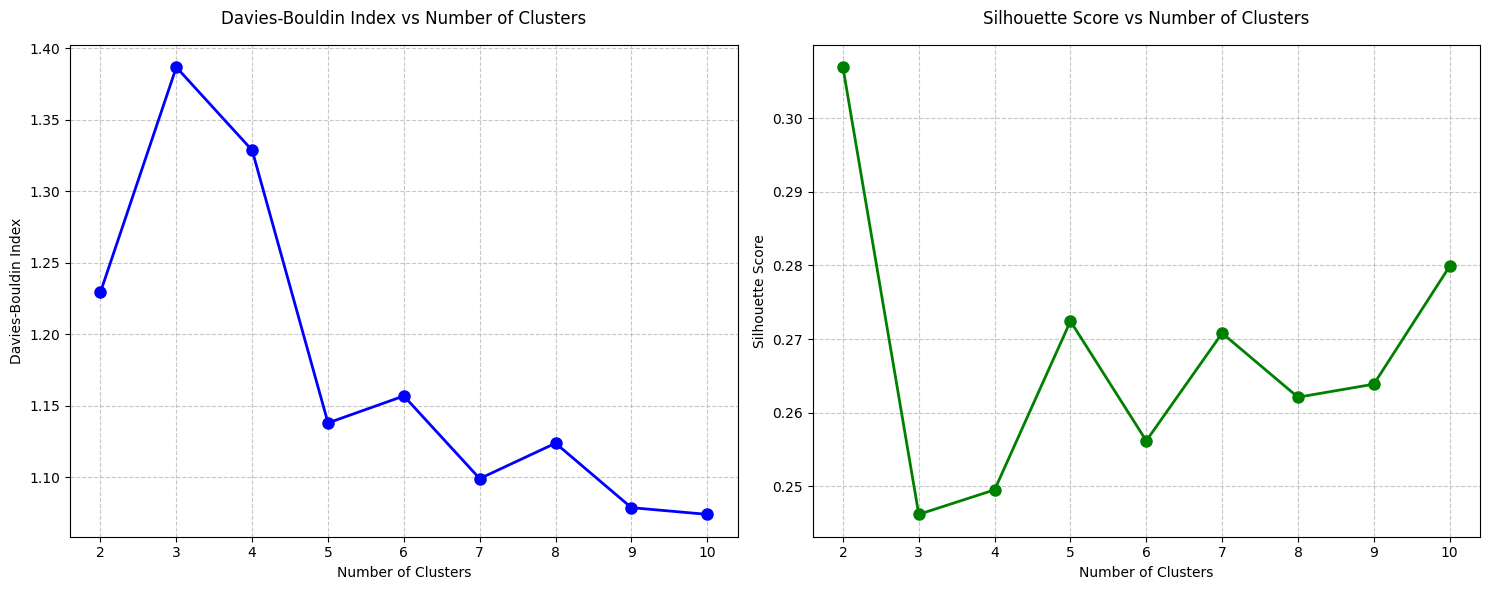

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


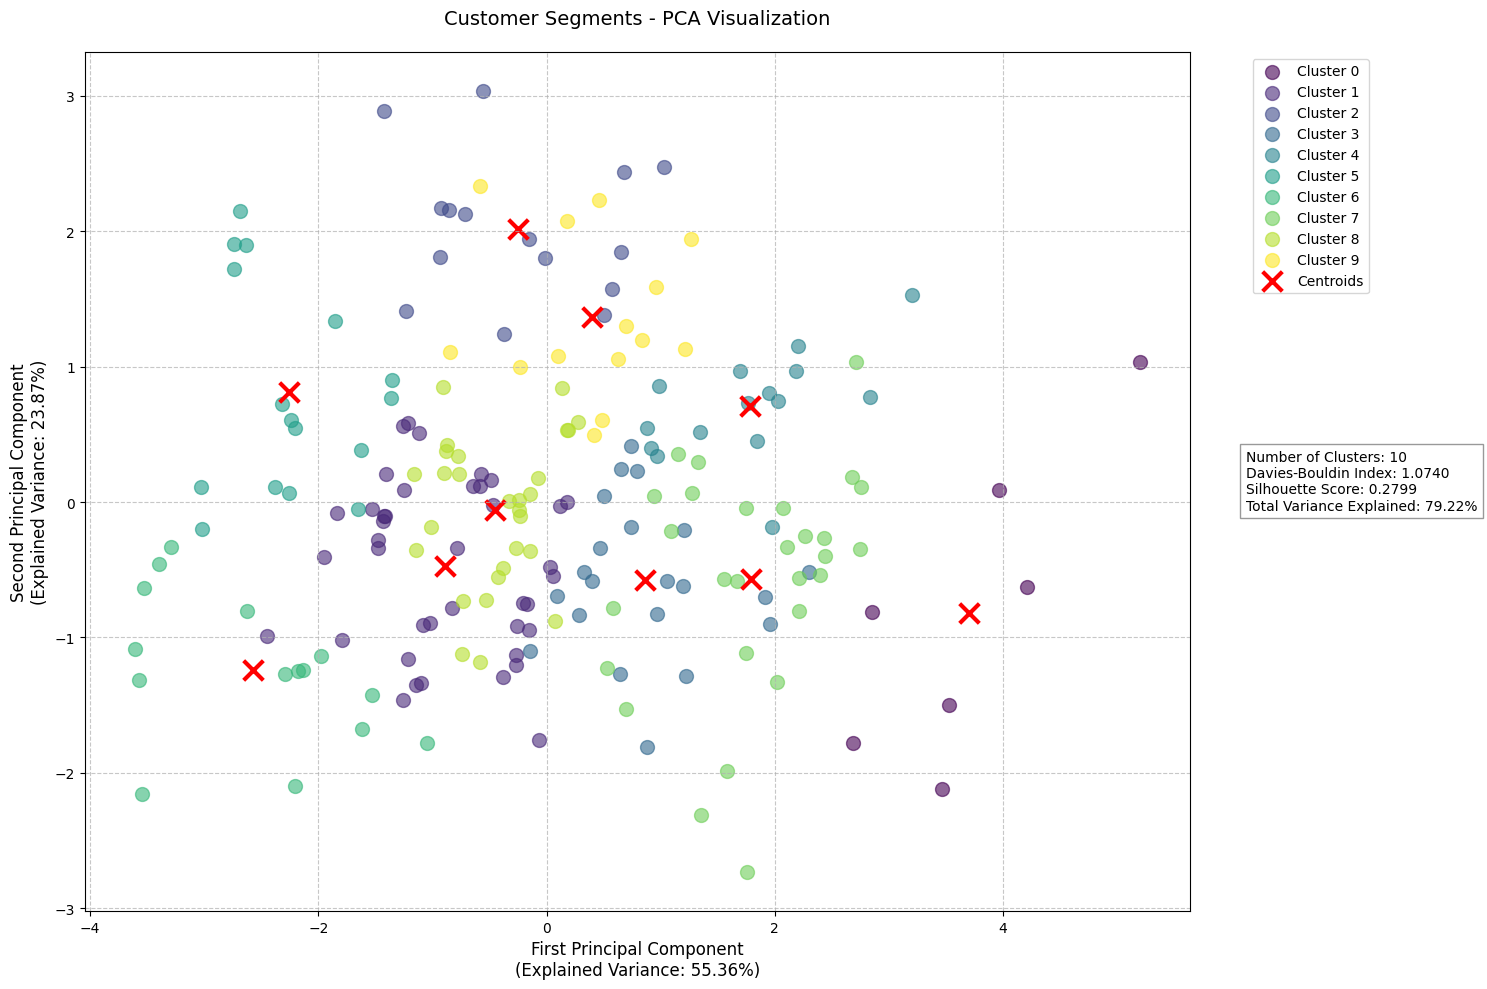

In [59]:
# Plot the DB Index and Silhouette Score for different cluster numbers
plt.figure(figsize=(15, 6))

# Plot Davies-Bouldin Index
plt.subplot(1, 2, 1)
plt.plot(cluster_range, db_indices, marker='o', linestyle='-', color='blue', linewidth=2, markersize=8)
plt.title('Davies-Bouldin Index vs Number of Clusters', fontsize=12, pad=15)
plt.xlabel('Number of Clusters', fontsize=10)
plt.ylabel('Davies-Bouldin Index', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(cluster_range)

# Plot Silhouette Score
plt.subplot(1, 2, 2)
plt.plot(cluster_range, silhouette_scores, marker='o', linestyle='-', color='green', linewidth=2, markersize=8)
plt.title('Silhouette Score vs Number of Clusters', fontsize=12, pad=15)
plt.xlabel('Number of Clusters', fontsize=10)
plt.ylabel('Silhouette Score', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(cluster_range)

plt.tight_layout()
plt.savefig('clustering_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

# Visualize the best clustering model using PCA
best_labels = best_kmeans.labels_

# Perform PCA to reduce dimensions to 2 for visualization
pca = PCA(n_components=2)
pca_components = pca.fit_transform(customer_data[numerical_features])

# Create main PCA visualization
plt.figure(figsize=(15, 10))
n_clusters = len(np.unique(best_labels))
colors = plt.cm.viridis(np.linspace(0, 1, n_clusters))

# Plot individual clusters
for i in range(n_clusters):
    cluster_points = pca_components[best_labels == i]
    plt.scatter(
        cluster_points[:, 0],
        cluster_points[:, 1],
        c=[colors[i]],
        label=f'Cluster {i}',
        s=100,
        alpha=0.6
    )

# Add cluster centers
cluster_centers_pca = pca.transform(best_kmeans.cluster_centers_)
plt.scatter(
    cluster_centers_pca[:, 0],
    cluster_centers_pca[:, 1],
    c='red',
    marker='x',
    s=200,
    linewidths=3,
    label='Centroids'
)

# Calculate and format explained variance
explained_variance = pca.explained_variance_ratio_
total_variance = sum(explained_variance)
plt.title('Customer Segments - PCA Visualization', fontsize=14, pad=20)
plt.xlabel(f'First Principal Component\n(Explained Variance: {explained_variance[0]:.2%})', fontsize=12)
plt.ylabel(f'Second Principal Component\n(Explained Variance: {explained_variance[1]:.2%})', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
# Add metrics text box
metrics_text = (
    f'Number of Clusters: {n_clusters}\n'
    f'Davies-Bouldin Index: {best_db_index:.4f}\n'
    f'Silhouette Score: {silhouette_avg:.4f}\n'
    f'Total Variance Explained: {total_variance:.2%}'
)
plt.text(1.05, 0.5, metrics_text, transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'),
         fontsize=10, verticalalignment='center')
plt.tight_layout()
plt.savefig('customer_segments_pca.png', dpi=300, bbox_inches='tight')
plt.show()



In [61]:
# Create cluster profile analysis
customer_data['Cluster'] = best_kmeans.labels_
print("\nCluster Profiles:")
cluster_profiles = customer_data.groupby('Cluster')[numerical_features].agg(['mean', 'std']).round(2)
print(cluster_profiles)

# Calculate cluster sizes
cluster_sizes = customer_data['Cluster'].value_counts().sort_index()
print("\nCluster Sizes:")
print(cluster_sizes)

# Save cluster analysis results
cluster_profiles.to_csv('cluster_profiles.csv')
pd.DataFrame({
    'Cluster': cluster_sizes.index,
    'Size': cluster_sizes.values
}).to_csv('cluster_sizes.csv', index=False)

# Print final metrics summary
print("\nFinal Clustering Metrics:")
print(f"Number of clusters: {n_clusters}")
print(f"Davies-Bouldin Index: {best_db_index:.4f}")
print(f"Silhouette Score: {silhouette_avg:.4f}")
print(f"Total variance explained by PCA: {total_variance:.2%}")


Cluster Profiles:
        total_spent       num_transactions       num_products_bought        \
               mean   std             mean   std                mean   std   
Cluster                                                                      
0              1.84  1.13             2.33  0.31                2.35  0.18   
1             -0.58  0.35            -0.50  0.42               -0.48  0.47   
2              0.27  0.56            -0.56  0.46               -0.55  0.46   
3              0.12  0.43             0.81  0.47                0.86  0.40   
4              1.29  0.55             0.90  0.34                0.84  0.34   
5             -1.15  0.30            -1.44  0.37               -1.43  0.38   
6             -1.55  0.22            -1.20  0.62               -1.18  0.64   
7              0.94  0.67             1.06  0.43                1.03  0.43   
8             -0.34  0.32            -0.14  0.24               -0.14  0.30   
9              0.68  0.45            -0.24  0